In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import random

### Runge Kutta

In [64]:
def rungeKuttaStep(f, dt, t0, w0):
    """
    Given wi aproximation, apply a runge kutta step to calculate w(i+1)
    
    Args:
        f (Callable) : the function f that where dy/dt = f(y, t)
        dt (float) : size of the step
        t0 (float) : current point at time, correspond to the time of wi
        w0 (float) : current approximation at time, note that w0 = wi
    
    Return:
        w(i+1) the next point in the integration
    """
    f1 = f(t0, w0)
    f2 = f(t0 + (dt / 2), w0 + (dt / 2) * f1)
    f3 = f(t0 + (dt / 2), w0 + (dt / 2) * f2)
    f4 = f(t0 + dt, w0 + dt * f3)

    return w0 + (dt / 6) * (f1 + 2*f2 + 2*f3 + f4)


def rungeKuttaSolver(system, initial_conditions, t0, t_max, dt):
    """
    Solves a system of first-order ordinary differential equations (ODEs) using the 4th-order Runge-Kutta method.

    Args:
        system (Callable) : A function that represents the system of ODE, can be only one
        initial_conditions (list[float]) : [u_1(t0), u_2(t0), ..., u_m(t0)]   
        t0 (float) : initial value for the system
        t_max (float) : max value for the system
        dt (float) : size of each step in the integration

    Return:
        tuple:
            np.array : the values at which we are aproximatting
            np.array : 2D vector where the value at the i row, j col is the aproximation of u_i on t_j 
    """

    m = 1 if np.isscalar(initial_conditions) else len(initial_conditions)
    points = int((t_max - t0) / dt)
    
    t = np.zeros(points)
    y = np.zeros((m, points))

    y[:, 0] = initial_conditions
    t[0] = t0

    for i in range(points - 1):
        t[i + 1] = t[i] + dt
        y[:, i + 1] = rungeKuttaStep(system, dt, t[i], y[:, i])

    return t, y
    

### Sloshing Model

Parametros que me los saque de la nada

In [65]:
W = 1
OMEGA = 1
LAMBDA = 1
EPSILON = 0.1

parametros que me los saque con ayuda de chatgpt, los dejo por si acaso

In [107]:
PI = np.acos(-1)
R = random.uniform(2.5, 6.7)
H = random.uniform(5.7, 8.9)
h = random.uniform(5.10, 10)
fcup = random.uniform(2.6, 4.3)
fstep = random.uniform(1, 2.5)
deltaz = random.uniform(2, 5)

r0 = 0.54*R
g = 980.665
W = 2*PI*fstep
OMEGA = fstep / fcup
EPSILON = 0.01
LAMBDA = -deltaz / r0

In [108]:
def verticalMotion(t, system):
    """
    Ordinary Differential Equation from the paper labeled as (4)
    As a system of first-grade ordinary differential equations
    
    Args:
        t: parameter of the ordinary differential equation (4)
        system: [u, du/dt]

    Return
        [du/dt, d2u/dt2]
    """
    u, dudt = system
    tao = W * t
    d2udt2 = - (1 + EPSILON * LAMBDA * OMEGA**2 * np.cos(OMEGA * tao)) * (u - EPSILON**2 * u**3/6) 

    return np.array([dudt, d2udt2])

In [111]:
initial_conditions = [2, 2] # me los saque de la nada
t0 = 0
t_max = 15
dt = 0.01
t, u = rungeKuttaSolver(verticalMotion, initial_conditions, t0, t_max, dt) # my solution
solution = scipy.integrate.solve_ivp(verticalMotion, (t0, t_max), initial_conditions, t_eval=t) # scipy solution
scipy_u = solution.y

plot results

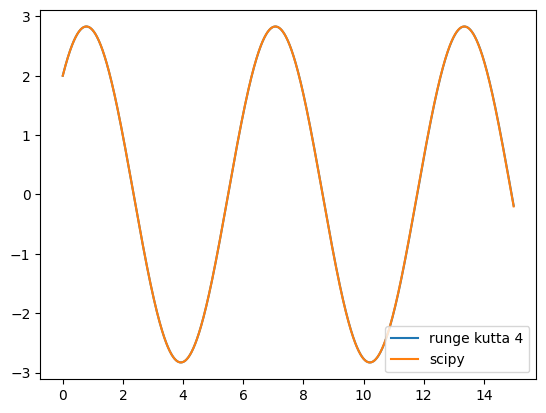

In [112]:
plt.plot(t, u[0], label="runge kutta 4") # u[0] refers to the 0 derivative of u, that means the u function itself
plt.plot(t, scipy_u[0], label="scipy")
plt.legend()
plt.show()